# Machine Learning Final Project: Predicting Hotel Demand

## 0.0 read data

In [1]:
import numpy as np
from numpy import linalg
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import time
from datetime import *
import copy

In [127]:
df_origin = pd.read_csv('./data/train.csv')
label = pd.read_csv('./data/train_label.csv')
df_test = pd.read_csv('./data/test.csv')

In [128]:
df_train = df_origin.loc[:74842, :]
df_val = df_origin.loc[74843:, :]

## 0.1.0 preprocessing

In [107]:
y_isCan = df_origin['is_canceled']
y_adr = df_origin['adr']
df_origin.drop(columns=['reservation_status', 'reservation_status_date', 'is_canceled', 'adr'], inplace = True)

In [5]:
concate = pd.concat([df_origin,df_test],axis=0).reset_index(drop = True)

In [6]:
concate.isna().sum()

ID                                     0
hotel                                  0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

### 0.1.1 dropna

In [7]:
concate = concate.drop(columns=['country', 'agent', 'company'])

### 0.1.2 fill 'children' with its median

In [8]:
concate = concate.fillna(concate.children.median())

### 0.1.2 map month to integer code

In [9]:
concate['arrival_date_month'] = concate['arrival_date_month'].map({'January':1, 'February': 2, 'March':3, 'April':4, 'May':5, 'June':6, 'July': 7, 'August':8, 'September':9, 'October': 10, 'November': 11, 'December':12})
concate.arrival_date_month = concate.arrival_date_month.astype(int)

### 0.1.3 convert date to weekday

In [10]:
def dateToWeekDay(df):
    year = df.arrival_date_year
    month = df.arrival_date_month
    day = df.arrival_date_day_of_month
    n = len(df)
    weekDays = [0 for i in range(n)]
    for i in range(n):
        weekDays[i] = date(year[i], month[i], day[i]).weekday()   
    # return 1~7
    df1 = copy.deepcopy(df)
    df1.insert(6,'weekDay', weekDays)
#     df1 = pd.get_dummies(df1, columns = ['weekDay'])
#     print(df1.columns)
#     df1 = df1.drop(columns = ['weekDay_6']) # remove last one
    return df1;

In [11]:
concate = dateToWeekDay(concate)

### 0.1.4 convert categorical variables to integer codes

In [12]:
# Creating dummy variables:
concate['hotel'] = concate['hotel'].astype('category').cat.codes
concate['arrival_date_month'] = concate['arrival_date_month'].astype('category').cat.codes
concate['meal'] = concate['meal'].astype('category').cat.codes
concate['market_segment'] = concate['market_segment'].astype('category').cat.codes
concate['distribution_channel'] = concate['distribution_channel'].astype('category').cat.codes
concate['reserved_room_type'] = concate['reserved_room_type'].astype('category').cat.codes
concate['assigned_room_type'] = concate['assigned_room_type'].astype('category').cat.codes
concate['deposit_type'] = concate['deposit_type'].astype('category').cat.codes
concate['customer_type'] = concate['customer_type'].astype('category').cat.codes
concate['weekDay'] = concate['weekDay'].astype('category').cat.codes
print(concate.columns)

Index(['ID', 'hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
       'arrival_date_week_number', 'weekDay', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'required_car_parking_spaces',
       'total_of_special_requests'],
      dtype='object')


In [13]:
concate.isna().sum()

ID                                0
hotel                             0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
weekDay                           0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64

### 0.2.0 splitting train/validation/test set

#### Building X and y

#### Splitting train/validation
(isCan/adr)

Split data at index 74843 (2016/11/30)

:74842 -> train

74843: -> val

In [14]:
# y_isCan, y_adr 要切 train, val
y_train_isCan = y_isCan.loc[:74842]
y_train_adr = y_adr.loc[:74842]
y_val_isCan = y_isCan.loc[74843:]
y_val_adr = y_adr.loc[74843:]

#concate 要切 train, val, test
X_train = concate.loc[:74842, :]
X_val = concate.loc[74843:91530, :]
X_test = concate.loc[91531:, :]

In [15]:
X_train_all = concate.loc[:91530, :]
y_train_all_isCan = y_isCan.loc[:91530]
y_train_all_adr = y_adr.loc[:91530]

In [16]:
print(len(y_train_isCan))
print(len(y_train_adr))
print(len(y_val_isCan))
print(len(y_val_adr))
print(len(X_train))
print(len(X_val))
print(len(X_test))

74843
74843
16688
16688
74843
16688
27859


## 1.0 Basic analysis

#### "is_canceled"

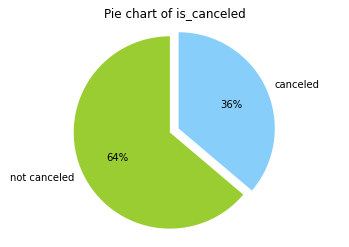

In [27]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'not canceled', 'canceled'
sizes = [y_train_isCan.value_counts(normalize=True)[0], y_train_isCan.value_counts(normalize=True)[1]]
colors = ['yellowgreen','lightskyblue']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%2.0f%%', shadow=False, startangle=90)
plt.title("Pie chart of is_canceled")
plt.axis('equal')
plt.show()

#### "adr"

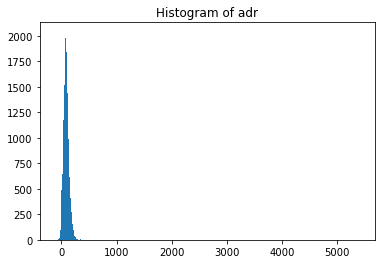

In [26]:
_ = plt.hist(y_train_adr, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of adr")
plt.show()

In [28]:
print("Maximum of adr: ", max(y_train_adr))
print("Minimum of adr: ", min(y_train_adr))

Maximum of adr:  5399.424061287761
Minimum of adr:  -118.23836167072805


#### "label"

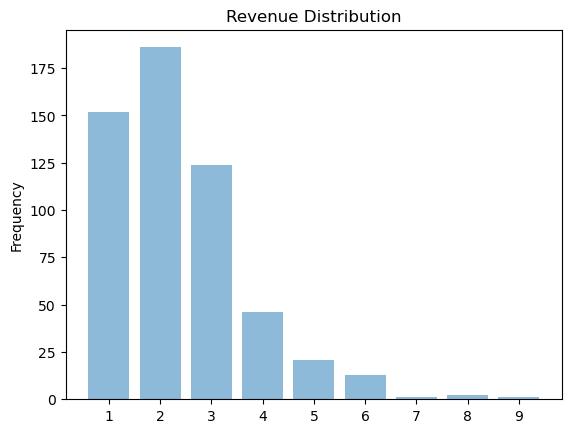

In [37]:
plt.rcdefaults()

objects = ('1', '2', '3', '4', '5', '6', '7', '8', '9')
y_pos = np.arange(len(objects))
performance = [label['label'].value_counts()[1], label['label'].value_counts()[2], label['label'].value_counts()[3], \
               label['label'].value_counts()[4], label['label'].value_counts()[5], label['label'].value_counts()[6], \
               label['label'].value_counts()[7], label['label'].value_counts()[8], label['label'].value_counts()[9]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Revenue Distribution')

plt.show()

## 2.0 Trivial

### 2.1 feature selection

In [38]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif # chi2 only takes non-negative, drop adr for now

In [39]:
def featureSelect_isCan(X_train, y_train, n): # select n best
    X_10_best= SelectKBest(chi2, k=n).fit(X_train, y_train)
    mask = X_10_best.get_support() #list of booleans for selected features
    new_feat = [] 
    for bool, feature in zip(mask, X_train.columns):
        if bool:
            new_feat.append(feature)
    print('The best features are:{}'.format(new_feat)) # The list of your 10 best features

In [40]:
def featureSelect_adr(X_train, y_train, n): # select n best
    X_10_best= SelectKBest(f_classif, k=n).fit(X_train, y_train)
    mask = X_10_best.get_support() #list of booleans for selected features
    new_feat = [] 
    for bool, feature in zip(mask, X_train.columns):
        if bool:
            new_feat.append(feature)
    print('The best features are:{}'.format(new_feat)) # The list of your 10 best features

In [41]:
len(X_train.columns)

27

In [42]:
featureSelect_isCan(X_train, y_train_isCan, 15)

The best features are:['ID', 'hotel', 'lead_time', 'arrival_date_week_number', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']


In [43]:
featureSelect_adr(X_train, y_train_adr, 15)

The best features are:['ID', 'hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type']


/Users/joannehuang/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning:

divide by zero encountered in true_divide



In [44]:
X_train_isCan = X_train[['ID', 'hotel', 'lead_time', 'arrival_date_week_number', 'distribution_channel', \
                         'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', \
                         'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', \
                         'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']]
X_train_adr = X_train[['ID', 'hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', \
                       'adults', 'children', 'babies', 'meal', 'previous_cancellations', 'previous_bookings_not_canceled',\
                       'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type']]
X_val_isCan = X_val[['ID', 'hotel', 'lead_time', 'arrival_date_week_number', 'distribution_channel', \
                         'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', \
                         'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', \
                         'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']]
X_val_adr = X_val[['ID', 'hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', \
                       'adults', 'children', 'babies', 'meal', 'previous_cancellations', 'previous_bookings_not_canceled',\
                       'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type']]

In [45]:
X_train_all_isCan = X_train_all[['ID', 'hotel', 'lead_time', 'arrival_date_week_number', 'distribution_channel', \
                         'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', \
                         'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', \
                         'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']]
X_train_all_adr = X_train_all[['ID', 'hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', \
                       'adults', 'children', 'babies', 'meal', 'previous_cancellations', 'previous_bookings_not_canceled',\
                       'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type']]
X_test_isCan = X_test[['ID', 'hotel', 'lead_time', 'arrival_date_week_number', 'distribution_channel', \
                         'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', \
                         'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', \
                         'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']]
X_test_adr = X_test[['ID', 'hotel', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', \
                       'adults', 'children', 'babies', 'meal', 'previous_cancellations', 'previous_bookings_not_canceled',\
                       'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type']]

### 2.2 computing accuracy 

In [46]:
from sklearn.metrics import accuracy_score
def computeAccuracy(X, y, y_result): #x: test revenue, y: test label
    print("Accuracy =", accuracy_score(y, y_result))
    print("Number of mislabeled points out of a total %d points : %d"% (X.shape[0],(y != y_result).sum()))
    print("E_val = ", (y != y_result).sum() / X.shape[0])
    
from sklearn.metrics import r2_score
def calculateRsquare(X, y, y_result): #x: test revenue, y: test label
    print("R square =", r2_score(y, y_result))

## 3.0 Predict "is_can"

### 3.1 k-th Nearest Neighbor

In [47]:
def trainKNN(X_train, y_train, k, X_val):
    print("Pre-processing...")
    knn = KNeighborsClassifier(n_neighbors = k)
    print("Fitting...")
    knn_best = knn.fit(X_train, y_train)
    print("Predicting...")
    y_result = knn_best.predict(X_val)
    return y_result;

In [48]:
# no feature
for i in range(1, 6, 2):
    y_result = trainKNN(X_train, y_train_isCan, i, X_val)
    computeAccuracy(X_val, y_val_isCan, y_result)

Pre-processing...
Fitting...
Predicting...
Accuracy = 0.6678451581975072
Number of mislabeled points out of a total 16688 points : 5543
E_val =  0.33215484180249283
Pre-processing...
Fitting...
Predicting...
Accuracy = 0.6678451581975072
Number of mislabeled points out of a total 16688 points : 5543
E_val =  0.33215484180249283
Pre-processing...
Fitting...
Predicting...
Accuracy = 0.6678451581975072
Number of mislabeled points out of a total 16688 points : 5543
E_val =  0.33215484180249283


In [50]:
# with feature
y_result = trainKNN(X_train_isCan, y_train_isCan, 3, X_val_isCan)
computeAccuracy(X_val_isCan, y_val_isCan, y_result)

Pre-processing...
Fitting...
Predicting...
Accuracy = 0.6678451581975072
Number of mislabeled points out of a total 16688 points : 5543
E_val =  0.33215484180249283


### 3.2 Random Forest Classification

In [55]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

def trainRFC(X_train, y_train_isCan, X_val, random_mode, oob_state, min_leaf):
    rfr = RandomForestClassifier(random_state = random_mode, oob_score = oob_state, min_samples_leaf = min_leaf)
    rfr.fit(X_train, y_train_isCan)
    y_result = rfr.predict(X_val)
    return y_result

In [56]:
# with feature
y_result = trainRFC(X_train_isCan, y_train_isCan, X_val_isCan, 0, True, 10)
computeAccuracy(X_val_isCan, y_val_isCan, y_result)

Accuracy = 0.7661792905081496
Number of mislabeled points out of a total 16688 points : 3902
E_val =  0.23382070949185044


In [39]:
# no feature
min_leaf = [1, 10, 50]
for leaf in min_leaf:
    y_result = trainRFC(X_train_isCan, y_train_isCan, X_val_isCan, 0, True, leaf)
    computeAccuracy(X_val_isCan, y_val_isCan, y_result)

Accuracy = 0.763003355704698
Number of mislabeled points out of a total 16688 points : 3955
E_val =  0.236996644295302
Accuracy = 0.7661792905081496
Number of mislabeled points out of a total 16688 points : 3902
E_val =  0.23382070949185044
Accuracy = 0.7616850431447747
Number of mislabeled points out of a total 16688 points : 3977
E_val =  0.2383149568552253


#### train with whole training dataset (including validation)

In [90]:
y_isCan_all = trainRFC(X_train_all_isCan, y_train_all_isCan, X_test_isCan, 0, True, 10)

### 3.3 Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### solver: lbfgs, newton-cg, sag
def trainLogisticRegression(X_train, y_train, X_val):
    clf = LogisticRegression(random_state=0, penalty='l2', solver='newton-cg', multi_class='multinomial').fit(X_train, y_train)
    y_result = clf.predict(X_val)
    return(y_result)

In [43]:
# no feature
y_result = trainLogisticRegression(X_train, y_train_isCan, X_val)
computeAccuracy(X_val, y_val_isCan, y_result)

Accuracy = 0.7659995206136145
Number of mislabeled points out of a total 16688 points : 3905
E_val =  0.23400047938638543


C:\Users\pinjun Liu\Downloads\anaconda\lib\site-packages\sklearn\utils\optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [60]:
# with feature
y_result = trainLogisticRegression(X_train_isCan, y_train_isCan, X_val_isCan)
computeAccuracy(X_val_isCan, y_val_isCan, y_result)

Accuracy = 0.7476030680728667
Number of mislabeled points out of a total 16688 points : 4212
E_val =  0.25239693192713325


/Users/joannehuang/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



## 4.0 Predict "adr"

### 4.1 Linear Regression

In [73]:
from sklearn.linear_model import LinearRegression

def trainLinearRegression(X_train_adr, y_train_adr, X_val_adr):
    clf = LinearRegression().fit(X_train_adr, y_train_adr)
    y_result = clf.predict(X_val_adr)
    return(y_result)

In [ ]:
y_result = trainLinearRegression(X_train, y_train_adr, X_val)
calculateRsquare(X_val, y_val_adr, y_result)

### 4.2 Random Forest Regression

In [75]:
def trainRFR(X_train, y_train_adr, X_val, random_mode, oob_state, min_leaf):
    rfr = RandomForestRegressor(random_state = random_mode, oob_score = oob_state, min_samples_leaf = min_leaf)
    rfr.fit(X_train, y_train_adr)
    pred = rfr.predict(X_val)
    return pred

In [80]:
# with feature
y_result = trainRFR(X_train_adr, y_train_adr, X_val_adr, 0, True, 10)
calculateRsquare(X_val_adr, y_val_adr, y_result)

R square = 0.500844494392595


In [81]:
# no feature
min_leaf = [1, 10, 50]
for leaf in min_leaf:
    y_result = trainRFR(X_train, y_train_adr, X_val, 0, True, leaf)
    calculateRsquare(X_val, y_val_adr, y_result)

R square = 0.6056049624454187
R square = 0.5969313087589534
R square = 0.5406007411169285


#### train with whole training dataset (including validation)

In [56]:
y_adr_all = trainRFR(X_train_all_adr, y_train_all_adr, X_test_adr)

## 5.0 Calculate predicted daily revenue

In [83]:
def calculateDateRevenue(df):
    df['arrival_date_month'] = df['arrival_date_month'].map({'January':'01', 'February': '02', 'March':'03', 'April':'04', 'May':'05', 'June':'06', 'July': '07', 'August':'08', 'September':'09', 'October': '10', 'November': '11', 'December':'12'})
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(1, "01")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(2, "02")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(3, "03")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(4, "04")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(5, "05")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(6, "06")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(7, "07")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(8, "08")
    df['arrival_date_day_of_month'] = df['arrival_date_day_of_month'].replace(9, "09")
    df1 = df[["arrival_date_year", "arrival_date_month", "arrival_date_day_of_month", "adr", "is_canceled", "stays_in_weekend_nights", "stays_in_week_nights"]].copy()
    df1["revenue"] = (1 - df1["is_canceled"]) * df1["adr"] * (df1["stays_in_week_nights"] + df1["stays_in_weekend_nights"])
    df1["arrival_date"] = df1["arrival_date_year"].astype(str) + "-" + df1["arrival_date_month"] + "-" + df1["arrival_date_day_of_month"].astype(str)
    df2 = df1[['arrival_date', 'revenue']]
    df2 = df2.groupby(by="arrival_date").sum()
    return(df2) # one column: revenue

### 5.1 Revenue to label 

In [129]:
revenue_train = calculateDateRevenue(df_train)
revenue_val = calculateDateRevenue(df_val)

/Users/joannehuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/joannehuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/joannehuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [130]:
revenue_train = revenue_train.merge(label_train, on='arrival_date')
revenue_val = revenue_val.merge(label_val, on='arrival_date')

label_train = label.loc[:518, :]
label_val = label.loc[519:, :]

In [132]:
revenue_val

,arrival_date,revenue,label
0,2016-12-01,18255.662091,1.0
1,2016-12-02,19889.133447,1.0
2,2016-12-03,27734.002145,2.0
3,2016-12-04,15142.260207,1.0
4,2016-12-05,23293.063788,2.0
...,...,...,...
116,2017-03-27,26217.381380,2.0
117,2017-03-28,16185.177703,1.0
118,2017-03-29,24002.255525,2.0
119,2017-03-30,33095.297394,3.0


### 5.2 Desicion Stump

In [52]:
from sklearn import tree

def trainDecisionStump(X_train, y_train, X_val):
    clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
    y_result = clf.predict(X_val)
    return(y_result)

def trainDecisionStumpRegressor(X_train, y_train, X_val):
    clf = tree.DecisionTreeRegressor(max_depth=10).fit(X_train, y_train)
    y_result = clf.predict(X_val)
    return(y_result)

In [ ]:
rev_train = pd.DataFrame({'rev': revenue_train['revenue'].tolist()})
lab_train = revenue_train['label'].tolist()
rev_val = pd.DataFrame({'rev': revenue_val['revenue'].tolist()})
lab_val = revenue_val['label'].tolist()

In [ ]:
y_result = trainDecisionStump(rev_train, lab_train, rev_val)

### 5.2.1 compute validation accuracy

In [136]:
computeAccuracy(rev_val,lab_val,y_result)

Accuracy = 0.9917355371900827
Number of mislabeled points out of a total 121 points : 1
E_val =  0.008264462809917356


## 6.0 Test

### 6.1 Train the whole dataset for revenue

In [ ]:
revenue_train_all = calculateDateRevenue(df_origin)
label["ID"] = label.index
revenue_train_all = revenue_train_all.merge(label, on='arrival_date')
rev_train_all = pd.DataFrame({'rev': revenue_train_all['revenue'].tolist()})
lab_train_all = pd.DataFrame({'lab': revenue_train_all['label'].tolist()})

In [140]:
df_fin = df_test[['arrival_date_month', 'arrival_date_year',\
                  'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights']].copy()
df_fin.insert(0, 'is_canceled', y_isCan_all)
df_fin.insert(1, 'adr', y_adr_all)
df_test_rev = calculateDateRevenue(df_fin)

In [142]:
df_test_rev

,revenue
arrival_date,
2017-04-01,27363.731676
2017-04-02,22195.240044
2017-04-03,29558.047116
2017-04-04,12835.407776
2017-04-05,25842.868707
...,...
2017-08-27,28819.782979
2017-08-28,56409.527265
2017-08-29,21254.173135


### 6.2 Decision stump to predict label

In [143]:
rev_test = pd.DataFrame({'rev': df_test_rev['revenue'].tolist()})
y_result = trainDecisionStump(rev_train_all, lab_train_all, rev_test, 10, 2)

In [146]:
pd.Series(y_result).value_counts()

2.0    82
3.0    38
1.0    27
4.0     5
5.0     1
dtype: int64

### 6.3 Export to csv

In [148]:
df_test_rev.insert(1, 'label', y_result.astype(int))

In [149]:
df_final = df_test_rev.drop(columns = ['revenue'])
df_final.to_csv('test_label.csv')